<a href="https://colab.research.google.com/github/leoxiang66/machine-learning/blob/MLO/homework/homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git lfs install
!git clone https://huggingface.co/datasets/Adapting/MLO

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'MLO'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [2]:
%cd /content/MLO
!ls

/content/MLO
hitters.x.csv  hitters.y.csv  README.md


In [3]:
import csv
import numpy as np
import torch
from torch import linalg as LA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
X = np.loadtxt('hitters.x.csv', delimiter=',', skiprows=1)
with open('hitters.x.csv', 'r') as f:
  X_colnames = next(csv.reader(f))

y = np.loadtxt('hitters.y.csv', delimiter=',', skiprows=1)


In [5]:
X_colnames

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'LeagueN',
 'DivisionW',
 'PutOuts',
 'Assists',
 'Errors',
 'NewLeagueN']

**1. Standarization**

In [6]:
standart_deviations = np.std(X, axis=0)
X_shape = np.shape(X)
X = X / standart_deviations

print(X[:3])

[[2.14246523 1.7984232  0.8008747  0.94150084 1.47096049 1.79916455
  2.92611931 1.51124009 1.29063939 0.84104122 0.97105495 1.28271737
  1.42286165 2.00326086 2.00036153 2.26197481 0.29695211 1.51652966
  2.00523962]
 [3.25790744 2.88635822 2.05939209 2.58912732 2.78708303 3.50606425
  0.62702557 0.7115842  0.70637389 0.7679072  0.6776209  0.8241614
  0.9979003  0.         2.00036153 3.14958518 0.56628076 2.12314153
  0.        ]
 [3.37353255 3.13058853 2.28821344 2.54989811 3.01933995 1.7068997
  2.29909374 2.46600731 2.43443957 2.74252571 2.50477726 2.59641825
  1.3431814  2.00326086 0.         0.71581481 0.07596449 0.4549589
  2.00523962]]


**2. Prepare lambdas**

In [7]:
delta = (7--3)/100
delta

0.1

In [8]:
lambdas  = list(10 ** np.linspace(-3, 7, 100))
lambdas[:10], lambdas[-1]

([0.001,
  0.0012618568830660211,
  0.0015922827933410922,
  0.002009233002565048,
  0.0025353644939701114,
  0.0031992671377973846,
  0.004037017258596553,
  0.0050941380148163806,
  0.006428073117284319,
  0.008111308307896872],
 10000000.0)

**3. Biased Ridge Regression**

Given $X, y$, we build biased features as $\tilde{X} = [1 \quad X]$, thus we have new weights $\tilde{\theta} = [m \quad \theta]^{T}$, where $m$ is the bias weight. The loss is defined as

$$
\text{loss} = \|\tilde{y}-y\|_2^2+\lambda\|\theta\|_2^2
$$, where $\tilde{y} = \tilde{X} \cdot \tilde{\theta}$

In [9]:
def biased_ridge_regression_estimate(X,y,lam, return_penalty = False, return_theta = False):
    '''
    compute the \tilde{\theta} solution
    '''
    n = X.shape[0]
    d = X.shape[1]

    X = torch.Tensor(X)
    y = torch.Tensor(y)

    tmp = torch.matmul(X.T,X)
    tmp += lam * torch.eye(d)
    tmp -= (torch.matmul(torch.matmul(X.T, torch.ones(n,n)),X))/n
    tmp = torch.inverse(tmp)
    tmp = torch.matmul(tmp, X.T)

    tmp2 = torch.eye(n) - (torch.ones(n,n))/n
    tmp2 = torch.matmul(tmp2,y)
    theta = torch.matmul(tmp, tmp2)

    m =  (torch.matmul(torch.ones(1,n),y-torch.matmul(X,theta)))/n

    theta_tilde = torch.concat([m, theta],dim =0)

    assert len(theta_tilde) == d+1

    if return_penalty:
        penalty = LA.vector_norm(theta)**2
        return theta_tilde, torch.log10(penalty)
    
    if return_theta:
        return theta

    return theta_tilde

In [10]:
biased_ridge_regression_estimate(X,y,lambdas[0])

tensor([ 163.1060, -291.0964,  337.7980,   37.8246,  -60.5212,  -26.9720,
         135.0598,  -16.7264, -390.8046,   86.8548,  -14.0557,  480.4399,
         260.4678, -213.8412,   31.2463,  -58.4169,   78.7617,   53.7249,
         -22.1618,  -12.3491])

**P4.3**

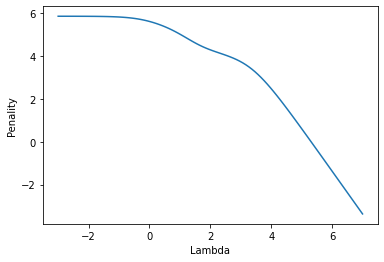

In [11]:
xpoints = lambdas.copy()
list.reverse(xpoints)
ypoints = [biased_ridge_regression_estimate(X,y,lam,return_penalty=True)[1] for lam in xpoints]



plt.plot(np.log10(xpoints), ypoints)
plt.xlabel('Lambda')
plt.ylabel('Penality')
plt.show()

We can see as the lambda increase, the penalty decrease and vice versa.

**P4.4**

In [12]:
rre = torch.Tensor(biased_ridge_regression_estimate(X,y,0.0000000000001, return_theta = True))

In [13]:
def least_square_estimate(X, y):
    tmp = torch.matmul(X.T, X)
    tmp = torch.inverse(tmp)
    tmp = torch.matmul(tmp,X.T)
    tmp = torch.matmul(tmp,y)

    return tmp

In [14]:
lse = least_square_estimate(torch.Tensor(X),torch.Tensor(y))

In [15]:
loss = torch.nn.MSELoss()

loss(rre,lse)

tensor(693.9199)

**P4.5**

In [16]:
X.shape

(263, 19)

In [17]:
tmp_x = X
tmp_y = y

batches = []

for i in [0.2,0.25,1/3,0.5]:
    
    tmp_x, X_test, tmp_y, y_test = train_test_split(
    tmp_x, tmp_y, test_size=i, random_state=0)

    batches.append((X_test,y_test))

batches.append((tmp_x,tmp_y))


In [18]:
x1,y1 = batches[0]
x2,y2 = batches[1]

In [19]:
tmp = np.concatenate([x1,x2], axis=0)
tmp.shape

(106, 19)

In [20]:
from sklearn.model_selection import train_test_split
def k_fold_cross_validation(k,X,y, loss_func, lam = None):

    # k等分dataset
    tmp_x = X
    tmp_y = y
    batches = []

    for i in [1/z for z in range(k,1,-1)]:
        tmp_x, X_test, tmp_y, y_test = train_test_split(
        tmp_x, tmp_y, test_size=i, random_state=0)

        batches.append((X_test,y_test))
    batches.append((tmp_x,tmp_y))

    # 计算k次
    val_losses = []
    for j in range(k):
        val_x, val_y = batches[j]
        train_indices = [i for i in range(k) if i != j]


        train_x = torch.concat([batches[x][0] for x in train_indices])
        train_y = torch.concat([batches[x][1] for x in train_indices])



        ## training
        rre = biased_ridge_regression_estimate(train_x,train_y,lam, return_theta = True)

        ## validation loss
        tmp = torch.matmul(val_x,torch.Tensor(rre))
        val_losses.append(loss_func(tmp,val_y))

    return torch.mean(torch.Tensor(val_losses))




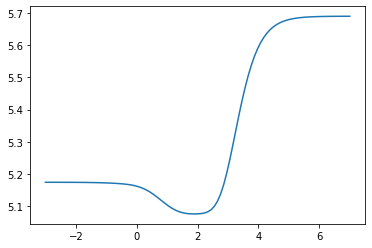

In [21]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = lambdas
ypoints = np.log10([k_fold_cross_validation(5,torch.Tensor(X),torch.Tensor(y),torch.nn.MSELoss(),x).numpy() for x in lambdas])

plt.plot(np.log10(xpoints), ypoints)
plt.show()

**P4.6**

In [22]:
best_lam = lambdas[np.argmin(ypoints)]
best_lam

70.54802310718645

The best $\lambda$ is 70.54802310718645

In [23]:
theta = biased_ridge_regression_estimate(X,y,best_lam, return_theta= True)

print(f"Theta: {theta}")

Theta: tensor([-10.0683,  57.3920,  -4.3689,  29.5286,  22.1207,  45.0601,  -9.4623,
         23.3200,  49.9671,  42.2850,  50.6466,  52.8905,  -5.2700,  17.1136,
        -52.5109,  61.3470,   9.6729, -16.0224,   1.1069])


Important attributes are those with large coefficients. Therefore, the following properties are relatively important：
- Hits
- CRuns
- CRBI
- CAtBat
- Walks
